In [2]:
# paquetes de la implementación
import numpy as np
import gym

# paquetes de las gráficas
import matplotlib.pyplot as plt


In [3]:
# entorno
env = gym.make('MountainCar-v0')

In [4]:
"""
Como Mountain Car es tiene un espacio de obs continuo, es necesario discretizar
se aplica Tile coding para generar particiones del espacio de obs, teniendo dos variables : posición y velocidad
"""
num_particion  = 8
particiones_por_dim = (8, 8) 


In [5]:
particiones_totales = num_particion * particiones_por_dim[0] * particiones_por_dim[1]

# cantidad de características y acciones
n_acciones = env.action_space.n 
n_caracteristicas = particiones_totales + 1

In [6]:
# límites del estado 
pos_min, pos_max = -1.2, 0.6
vel_min, vel_max = -0.07, 0.07

In [7]:
# parámetros 
alpha_actor = 0.1
alpha_critico = 0.1
gamma = 0.995

In [8]:
# función de características 
def caracteristicas(estado):
    pos, vel = estado[0], estado[1]
   
    ancho_particion_pos = (pos_max - pos_min) / (particiones_por_dim[0] - 1)
    ancho_particion_vel = (vel_max - vel_min) / (particiones_por_dim[1] - 1)
    
    
    features = np.zeros(particiones_totales)
    
    for pt in range(num_particion):
        
        offset_pos = (pt / num_particion) * ancho_particion_pos
        offset_vel = (pt / num_particion) * ancho_particion_vel
        
    
        indice_pos = int((pos - pos_min + offset_pos) / ancho_particion_pos)
        indice_vel = int((vel - vel_min + offset_vel) / ancho_particion_vel)
        
        # ver que los índices no sobrepasen el rank de las particiones
        if indice_pos >= particiones_por_dim[0]:
            indice_pos = particiones_por_dim[0] - 1
        if indice_vel >= particiones_por_dim[1]:
            indice_vel = particiones_por_dim[1] - 1
        
        
        indice_global = pt * (particiones_por_dim[0] * particiones_por_dim[1]) + indice_pos * particiones_por_dim[1] + indice_vel
        features[indice_global] = 1
    
    
    return np.append(features, 1.0)

In [9]:
# pesos iniciales
pesos_actor = np.random.rand(n_acciones, n_caracteristicas) * 0.01
pesos_critico = np.random.rand(n_caracteristicas) * 0.01

In [10]:
# softmax 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

In [11]:
# función de la política
def politica(estado):
    x = caracteristicas(estado)
    logits = pesos_actor.dot(x)
    probas = softmax(logits)
    return probas

In [12]:
# función de valor
def valor(estado):
    feat = caracteristicas(estado)
    return np.dot(pesos_critico, feat)

In [13]:
# función de promedio
def promedio(datos, vnv=10): # vnv: para el promedio de los episodios
    return np.convolve(datos, np.ones(vnv)/vnv, mode='valid')

In [14]:
# hiperparámetros
n_episodios = 1500
recompensas_episodios = []       
pasos_episodios = []            
pasos_totales = 0

In [15]:
for episodio in range(n_episodios):
    estado, _ = env.reset()
    terminado = False
    recompensa_total = 0
    
    while not terminado:
        feat = caracteristicas(estado)
        probas = politica(estado)
        accion = np.random.choice(n_acciones, p=probas)
        sig_estado, recompensa, terminado, trunco, _ = env.step(accion)
        terminado = terminado or trunco  
        recompensa_total = recompensa_total + recompensa
        pasos_totales = pasos_totales + 1
        
        # valor actual y el que sigue
        v = valor(estado)
        v_sig = valor(sig_estado)

        # (TD error)
        error_td = recompensa + gamma * v_sig * (1 - int(terminado)) - v
        
        # actualizar al actor
        pesos_critico = pesos_critico + alpha_critico * error_td * feat
        
        gradiente = -probas[:, None] * feat[None, :]
        gradiente[accion] = gradiente[accion] + feat  
        pesos_actor = pesos_actor + alpha_actor * error_td * gradiente
        
        estado = sig_estado
        
    recompensas_episodios.append(recompensa_total)
    pasos_episodios.append(pasos_totales)
    
    if (episodio+1) % 75 == 0:
        print(f"Episodio {episodio+1}: Recompensa Total = {recompensa_total}, Pasos Totales = {pasos_totales}")

C:\Users\ST\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodio 75: Recompensa Total = -200.0, Pasos Totales = 14975
Episodio 150: Recompensa Total = -92.0, Pasos Totales = 25305
Episodio 225: Recompensa Total = -112.0, Pasos Totales = 33829
Episodio 300: Recompensa Total = -143.0, Pasos Totales = 42420
Episodio 375: Recompensa Total = -164.0, Pasos Totales = 50920
Episodio 450: Recompensa Total = -145.0, Pasos Totales = 59983
Episodio 525: Recompensa Total = -146.0, Pasos Totales = 68795
Episodio 600: Recompensa Total = -111.0, Pasos Totales = 77659
Episodio 675: Recompensa Total = -92.0, Pasos Totales = 86143
Episodio 750: Recompensa Total = -161.0, Pasos Totales = 94708
Episodio 825: Recompensa Total = -83.0, Pasos Totales = 103815
Episodio 900: Recompensa Total = -84.0, Pasos Totales = 112390
Episodio 975: Recompensa Total = -140.0, Pasos Totales = 121511
Episodio 1050: Recompensa Total = -134.0, Pasos Totales = 130052
Episodio 1125: Recompensa Total = -90.0, Pasos Totales = 139132
Episodio 1200: Recompensa Total = -107.0, Pasos Totale

In [16]:
prom_recom = promedio(recompensas_episodios, vnv=10)
prom_pasos = pasos_episodios[9:]  

Gráfica de recompensa obtenida.
Eje x: pasos
Eje y : recompensa promedio


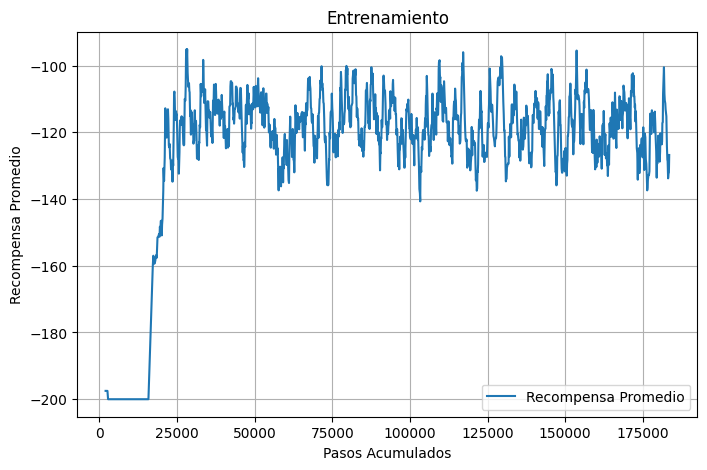

In [17]:
print("Gráfica de recompensa obtenida.")
print("Eje x: pasos")
print("Eje y : recompensa promedio")
plt.figure(figsize=(8,5))
plt.plot(prom_pasos, prom_recom, label='Recompensa Promedio')
plt.xlabel('Pasos Acumulados')
plt.ylabel('Recompensa Promedio')
plt.title('Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print("Política (pesos) del actor:")
print(pesos_actor)

Política (pesos) del actor:
[[ 5.75825360e-02 -4.70280697e+00 -8.21110076e-02 ... -6.57180629e-01
   4.78142160e-03  4.13441122e+00]
 [-5.58577929e-01  5.09503684e+00  1.28195104e+00 ...  2.27057789e+00
   4.18938443e-03 -1.09444590e+01]
 [ 5.17408001e-01 -3.76622921e-01 -1.18066059e+00 ... -1.60503526e+00
   7.65396522e-03  6.82674092e+00]]


In [19]:
# corrida sobre 10 experiementos

def eva_politica(env, pesos_actor, n_episodios=10):
    lista_recompensas = []
    for _ in range(n_episodios):
        estado, _ = env.reset()
        terminado = False
        recompensa_total = 0
        while not terminado:
            probas = politica(estado)
            accion = np.random.choice(n_acciones, p=probas)
            sig_estado, recompensa, terminado, trunco, _ = env.step(accion)
            terminado = terminado or trunco
            recompensa_total += recompensa
            estado = sig_estado
        lista_recompensas.append(recompensa_total)
    return lista_recompensas

recompensas_evaluacion = eva_politica(env, pesos_actor, n_episodios=10)
media_recompensa = np.mean(recompensas_evaluacion)
desviacion_recompensa = np.std(recompensas_evaluacion)

print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {desviacion_recompensa:<20.2f} |")
print("----------------------------------------------")


Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | -117.40              |
| Desviación   | 30.67                |
----------------------------------------------
